# Homework 4

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображенииа, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершут предобработку картинки, писанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер равномерно занимало место, то есть если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в приложении к этому занятию.

<table><tr>
    <td> <img src="https://i.ibb.co/fkScTsg/test_image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/q7PQRtZ/test_image_03.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/StTqhST/test_image_08.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
import math

In [2]:
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [3]:
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [4]:
def auto_canny(image, sigma=0.3):
    v = np.median(image)
    
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    return edged

In [5]:
def predprodact(image): # убераем подписи снизу у некоторых картинок 
    h, w, _ = image.shape
    if(image[h - 1].mean()  > 253):
        first = True
        for i in range(h // 2, len(image)):
            if(image[i].mean() > 253):
                image = image[0 : i]
                break;
    
    return image

In [6]:
def dots(corners, image):
    h, w, _ = image.shape 
    hm, wm = h // 2, w // 2
    deviation = []
    for i in range(len(corners)): # находим отклонение каждой точки от середины левого угла и правого угла
        now = []
        now.append(abs(0 - corners[i][0][1]) + abs(0 - corners[i][0][0]))
        now.append(abs(0 - corners[i][0][1]) + abs(w - corners[i][0][0]))
        now.append(abs( 4 * hm // 3 - corners[i][0][1]) + abs(wm - corners[i][0][0]))
        now.append(i)
        deviation.append(now)
    
    left = corners[sorted(deviation, key=lambda dev : dev[0])[0][3]][0]
    right = corners[sorted(deviation, key=lambda dev : dev[1])[0][3]][0]
    middle = corners[sorted(deviation, key=lambda dev : dev[2])[0][3]][0]
    
    return [left, right, middle]
        

In [7]:
def new_dots(left, right, middle, image):
    new_left, new_right, new_middle = left.copy(), right.copy(), middle.copy()
    new_left[1], new_right[1] = min(new_left[1], new_right[1]), min(new_left[1], new_right[1])
    new_middle[0] = (new_left[0] +new_right[0]) // 2
    
    return [new_left, new_right, new_middle]

In [8]:
def apply_warpAffine(image, points1, points2) -> np.ndarray: # аффинное преоброзование из 1 д/з
    image_height, image_width, _ = image.shape

    M = cv2.getAffineTransform(points1, points2)

    new_image_size = int(math.ceil(cv2.norm((image_height, image_width), normType=cv2.NORM_L2)))
    M[0, 2] += (new_image_size - image_width) // 2
    M[1, 2] += (new_image_size - image_height) // 2

    image = cv2.warpAffine(image, M, (new_image_size, new_image_size))

    bordersY = [0, image.shape[0]]
    j = 0;
    if(image[j].mean() > 0):
        j += 1
    
    for i in range(j, len(image) - 1):
        if (np.mean(image[i]) == np.mean(image[0]) and np.mean(image[i + 1]) != np.mean(image[0])
                or np.mean(image[i + 1]) == np.mean(image[0]) and np.mean(image[i]) != np.mean(image[0])):
            bordersY[j] = i + 1
            j += 1 

    bordersX = [0, image.shape[1]]
    j = 0
    if(image[:, j].mean() > 0):
        print(image[:, j].mean())
        j += 1
        
    for i in range(j, len(image[0]) - 1):
        if (np.mean(image[:, i]) == np.mean(image[:, 0]) and np.mean(image[:, i + 1]) != np.mean(image[:, 0])
                or np.mean(image[:, i + 1]) == np.mean(image[:, 0]) and np.mean(image[:, i]) != np.mean(image[:, 0])):
            bordersX[j] = i + 1
            j += 1
            
    image = image[bordersY[0]: bordersY[1], bordersX[0]: bordersX[1]]
    return image

In [9]:
def new_image(img): # уменьшаем размер картинки, делая размер хвоста больше относительного картинки
    i, i1, j, j1 = 0, 0, 0, 0
    for l in range(20):

            img = cv2.cvtColor(img[i : len(img) - j, i1 : len(img[0]) - j1], cv2.COLOR_BGR2RGB)
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray_img = cv2.medianBlur(gray_img, 5)
            gray_img = cv2.GaussianBlur(gray_img, (9,9), sigmaX = 1.5, sigmaY = 1.5)
            gray_img = auto_canny(gray_img)    

            i = 0
            for i in range(len(gray_img)):
                if(gray_img[i].mean() > 0.5):
                    break
            j = 0
            for j in range(len(gray_img)):
                if(gray_img[len(gray_img) - j - 1].mean() > 0.5):
                    break

            i1 = 0
            for i1 in range(len(gray_img[0])):
                if(gray_img[::, i1].mean() > 1):
                    break

            j1 = 0
            for j1 in range(len(gray_img[0])):
                if(gray_img[::, len(gray_img[0]) - j1 - 1].mean() > 1):
                    break
    img = cv2.cvtColor(img[i : len(img) - j, i1 : len(img[0]) - j1], cv2.COLOR_BGR2RGB)    
    return img

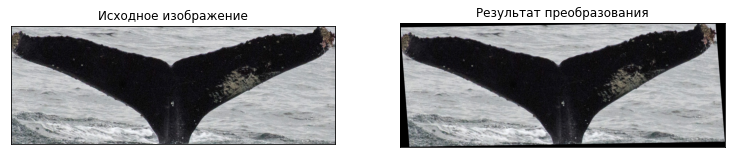

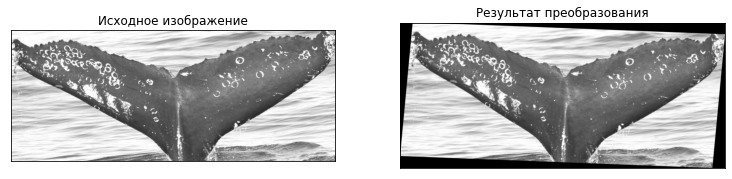

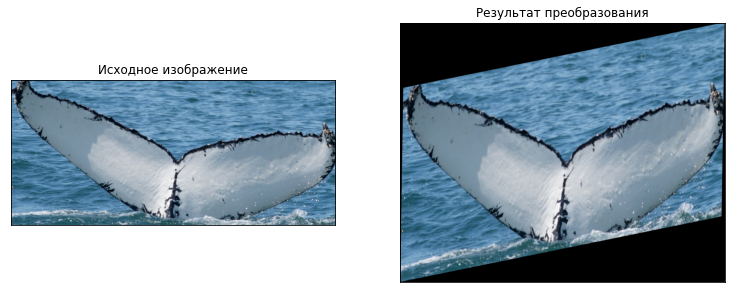

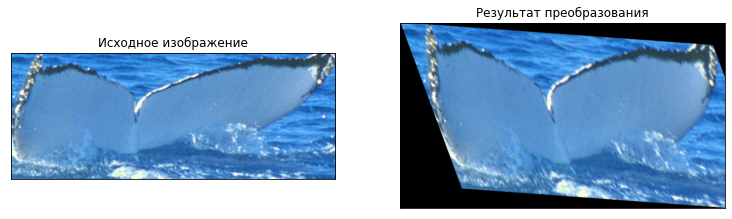

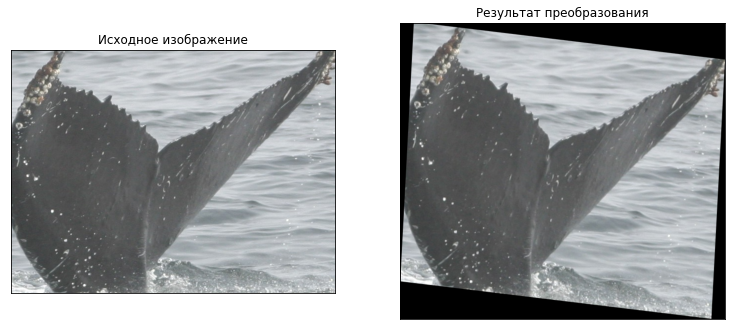

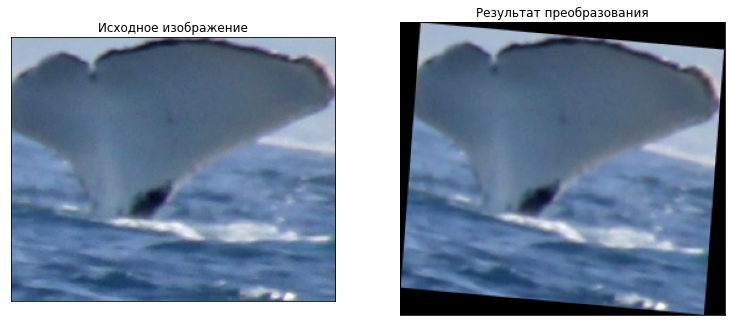

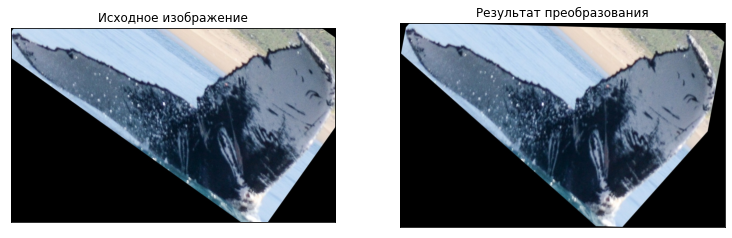

33.21378504672897


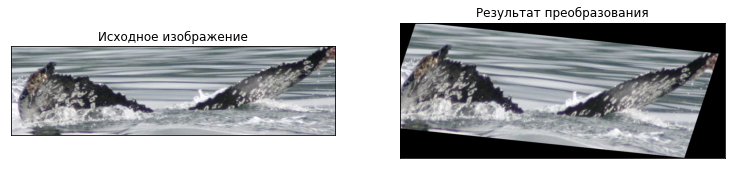

34.54974358974359


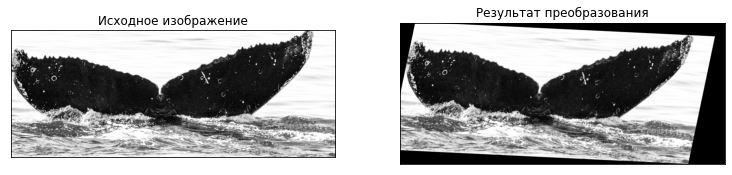

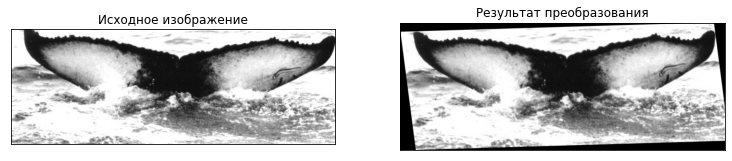

In [10]:
for i in range(10): 
    img = cv2.imread(f'whale_tail/test_image_0{i}.jpg')
    img = predprodact(img)
    img = new_image(img)

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.medianBlur(gray_img, 9)
    gray_img = cv2.GaussianBlur(gray_img, (11,11), sigmaX = 1, sigmaY = 1)
    gray_img = auto_canny(gray_img) 
    
    corners = cv2.goodFeaturesToTrack(gray_img, maxCorners=100, qualityLevel=0.1, minDistance=30, mask=None, blockSize=3, \
                                  gradientSize=11, useHarrisDetector=False, k=0.5)
    corners = np.int0(corners)
    
    old = dots(corners, img)
    new = new_dots(old[0], old[1], old[2], img)
    img1 = apply_warpAffine(img, np.float32(old), np.float32(new))
    
    plot_transform_result(img, img1)